## Bike Rental ##

In [1]:
from init.pre_process import pre_process
from init.models import models
import pandas as pd 
import numpy as np
import seaborn as sns

## Step 1: Reading the dataset

In [2]:
path = '/Users/ritika/Downloads/Bike-Sharing-Dataset/hour.csv'
df_bike_h = pre_process.load_data(path)

## Step 2:  Pre-processing
Explore the possibilities of cleaning the data and renaming the columns

<b> 1. Renaming the columns </b>

In [3]:
df_bike_h = pre_process.rename_columns(df_bike_h)

<b> 2. Checking and converting the data types </b>

In [4]:
pre_process.find_dtypes(df_bike_h)
df_bike_h = pre_process.convert_dtypes(df_bike_h)

Data types of the columns in dataset are: 
 instant         int64
date           object
season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object
Df with change data type:  instant                int64
date          datetime64[ns]
season              category
year                category
month               category
hour                   int64
holiday             category
weekday             category
workingday          category
weather             category
temp                 float64
atemp                float64
humidity             float64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object


As we see from the list above the following columns needs a change in the data type: <br>
   a) Date: from object to date <br>
   b) season,year,month,holiday,weekday,workingday,weather from int64 to category


<b> 3. Check for null/missing values in each column <b>

In [5]:
pre_process.check_missing_value(df_bike_h)

Missing values in the dataframe: 

instant       0
date          0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


<b> 4. For better clarity mapping the values(numbers) in season, month, weekday and weather columns to corresponding  description from the data description file <b>

In [6]:
df_bike_h = pre_process.map_col_values(df_bike_h)

## STEP 3:  Exploratory Data analysis and Feature Engineering

<b> 1) Outlier analysis using the box plot for count vs each categorical features </b>

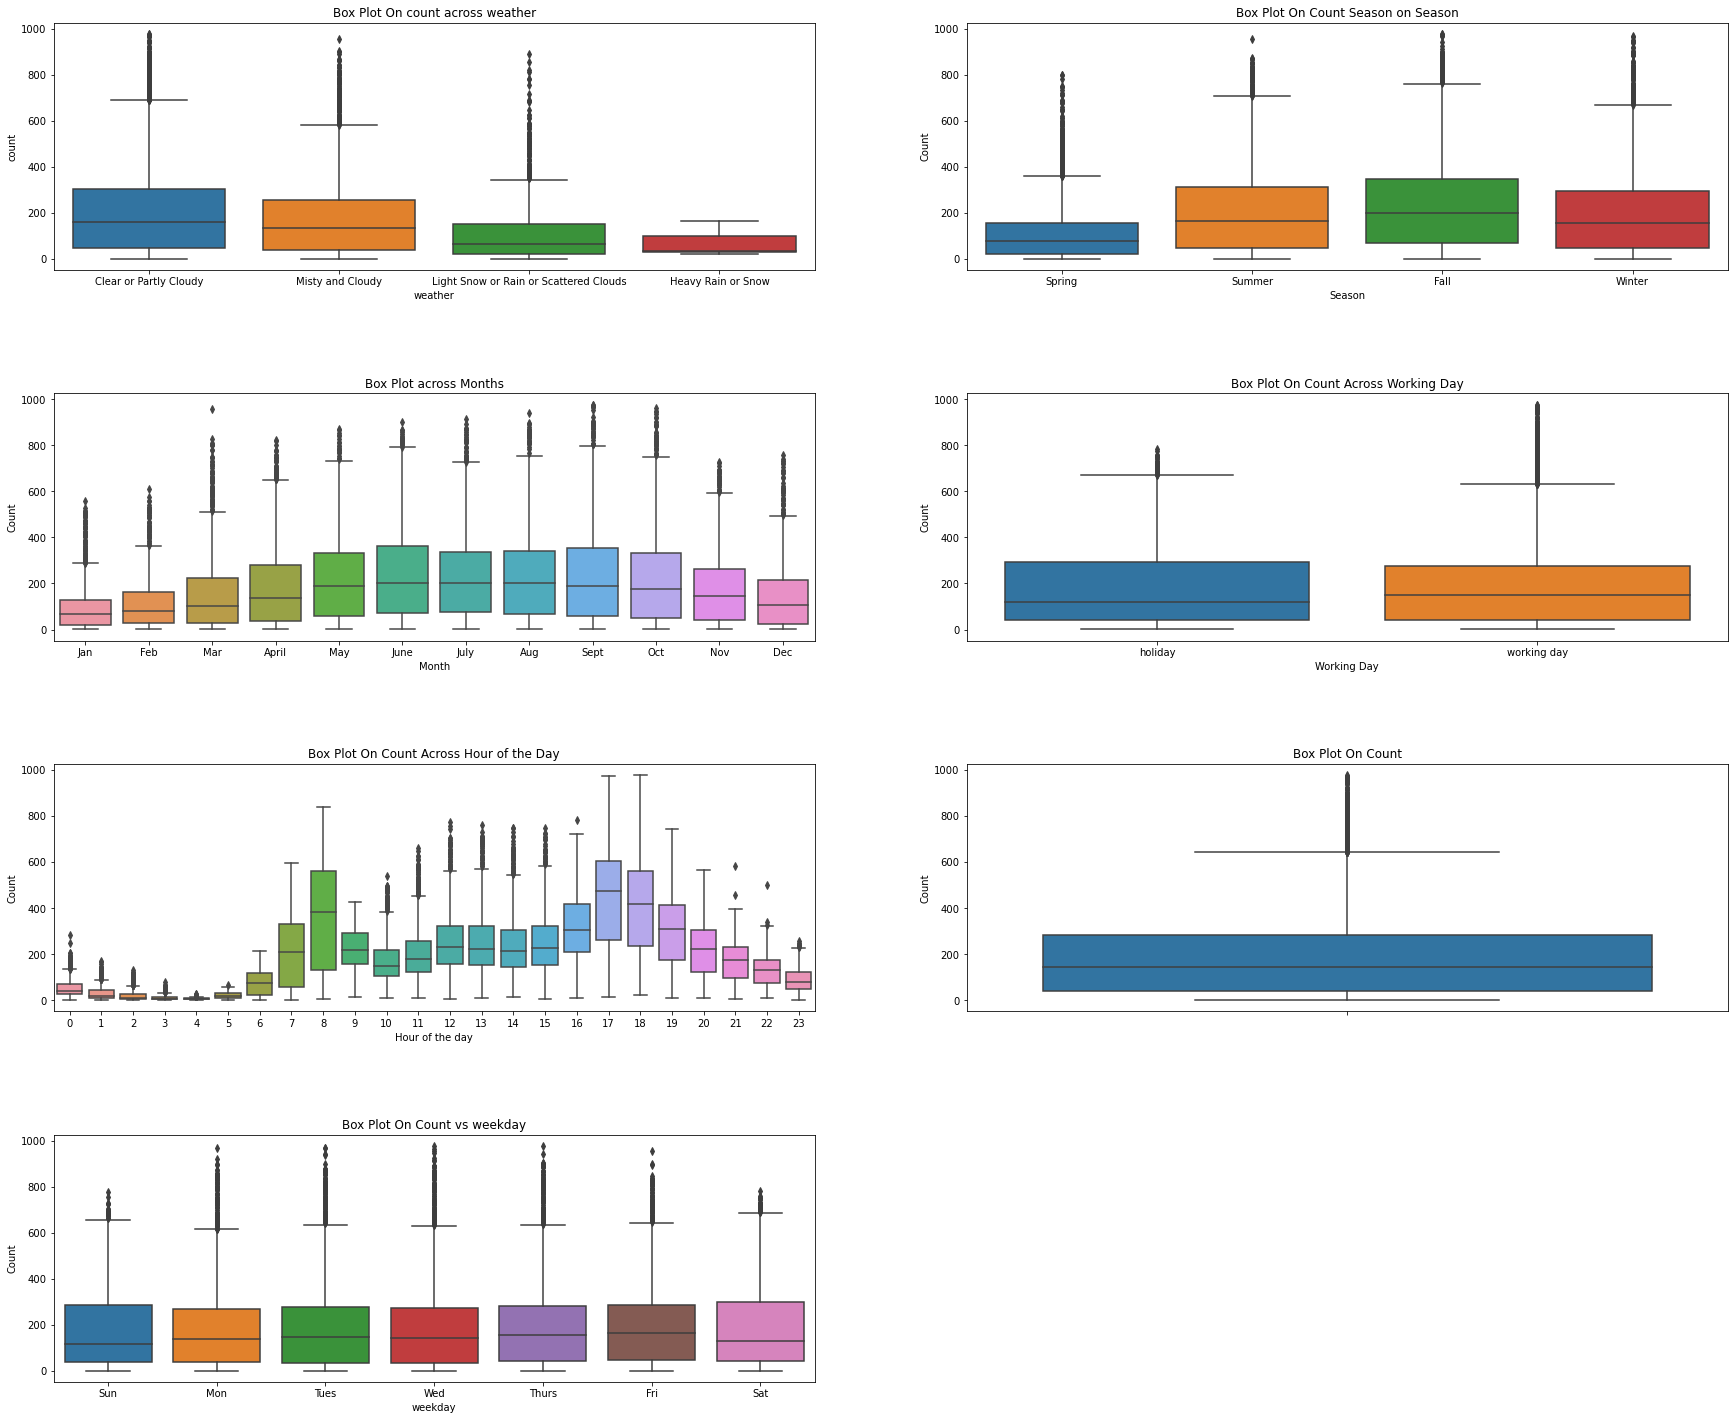

In [7]:
pre_process.outlier_analysis(df_bike_h)

Looking at the plots above, we can see that the target variable 'count' has many data points outside the maximum whisker which leads us to believe the presence of outliers in the dataset.

More insights from the plots above:

&emsp;   a) Spring season has got relatively lower count.The dip in median value in boxplot gives evidence for it.<br>
&emsp;   b) In the "Hour Of The Day" plot - the median value are higher at 7AM - 8AM and 5PM - 6PM. It can be attributed       to office users at that time.<br>
&emsp;   c) As expected the count median value on a clear weather is much higher than other weather conditions. <br>
&emsp;   d) Months in Summer and fall season see a higher median count value than other months and season.

<b> 2) Outlier treatment </b>

In [8]:
#removing the outlier points that are greater than mean + or - 3*standard deviation.
df_outlier_treat  = pre_process.outlier_removal(df_bike_h)

Shape Of the DataFrame Before Outliers:  (17379, 17)
Shape Of the DataFrame After Outliers:  (17135, 17)
Number of Outliers:  244


<b> 3) Check the distribution of target variable - 'count' <b>

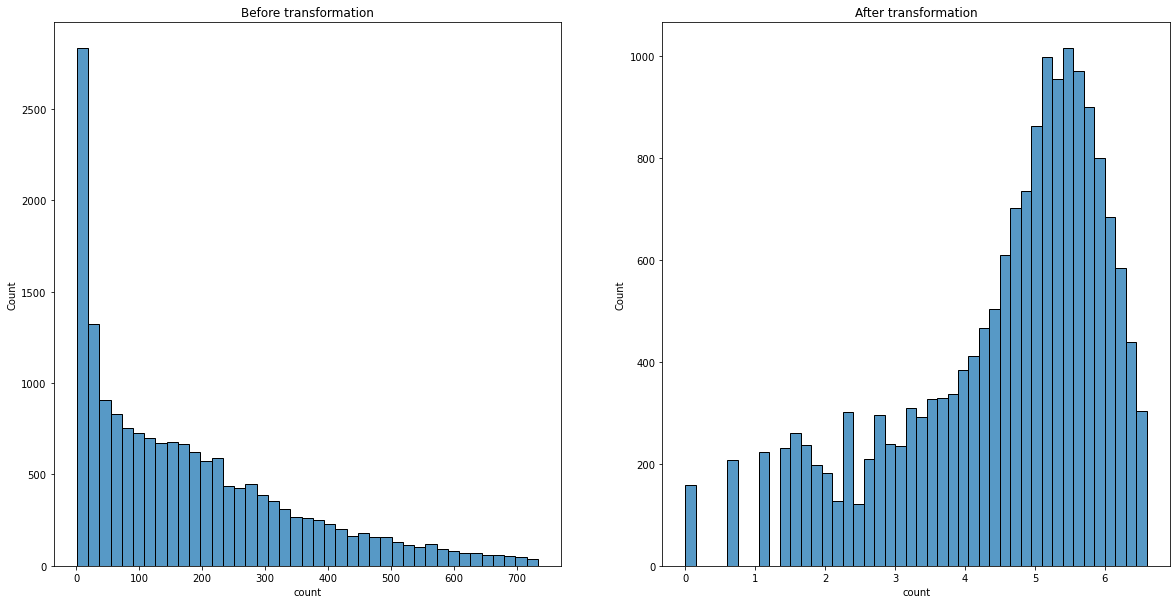

In [9]:
df_bike_norm = pre_process.normalisation(df_outlier_treat)

It is clear that the count variable is skewed towards right before transformation. Most of the machine learning techniques require dependent variable to be normally distributed, so the best practice would be to transform the skewed dependent variable to a normally distributed one. Taking log transformation on count variable after removing outliers makes the distribution much better, still not a perfect normal distribution though

<b> 4) Plotting the correlation matrix to perform correlation analysis on numerical features </b>

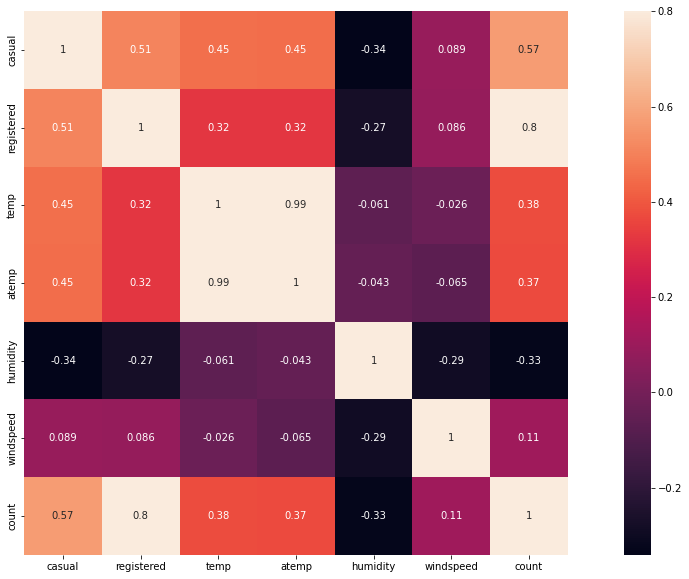

In [10]:
corr_mat= df_bike_norm[['casual','registered','temp','atemp','humidity','windspeed','count']].corr()
pre_process.corr_analysis(corr_mat)

Correlation matrix is used to understand how a dependent variable is influenced by numerical features. We can observe the following insights from the correlation matrix above: <br>

&emsp; a) 'atemp' and 'temp' are strongly correlated with each other. It is quite expected as the apparent                    temperature depends on the actual temperature. Hence one of the features has to be dropped since they              exhibit  multicollinearity in the data. We will drop 'atemp'.<br>

&emsp; b) 'Casual' and "Registered" will also be dropped as they are leakage variables because sum of casual and              registered is equal to total count. <br>

&emsp; c) 'temp' has positive correlation with count. Hence we keep this feature <br>

&emsp; d) 'humidity' features has negative correlation with count. <br>

&emsp; e) 'windspeed' has a very low correlation value with count. Hence it is very weakly correlated to count.              This feature will dropped as well.


In [11]:
#Based on analysis above, the following columns/features are removed for model building ('instant' and 'date' are redundant columns so removing that as well)
columns_to_remove = ['instant','date','atemp', 'casual', 'registered', 'windspeed']
df_bike = df_bike_norm.drop(columns_to_remove, axis=1,)

<b> 5) Plots to do further exploratory data analysis </b>

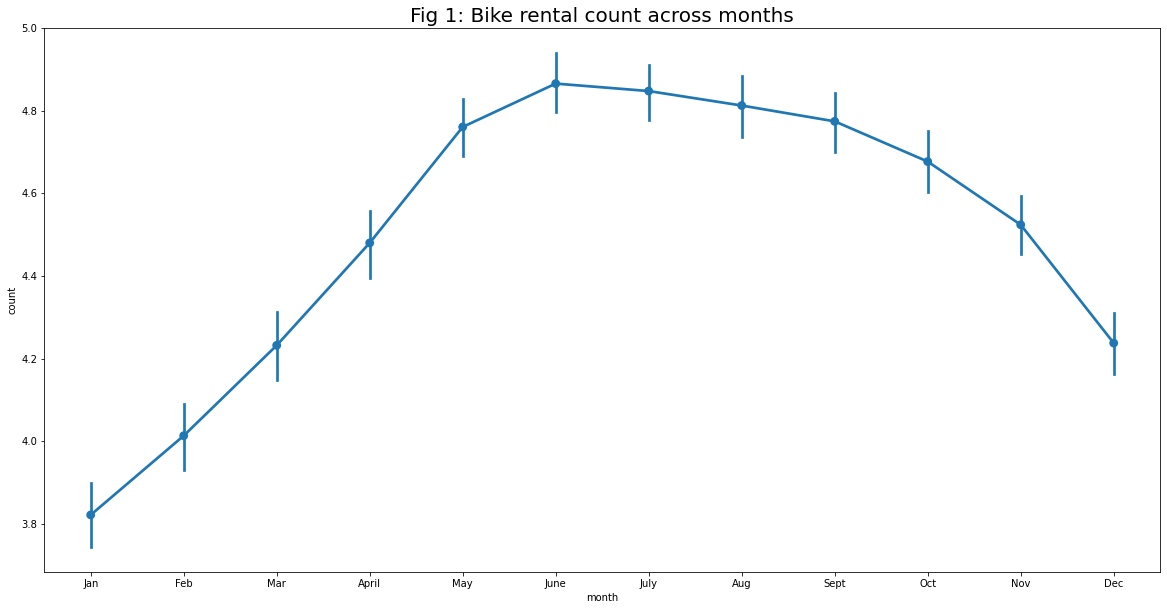

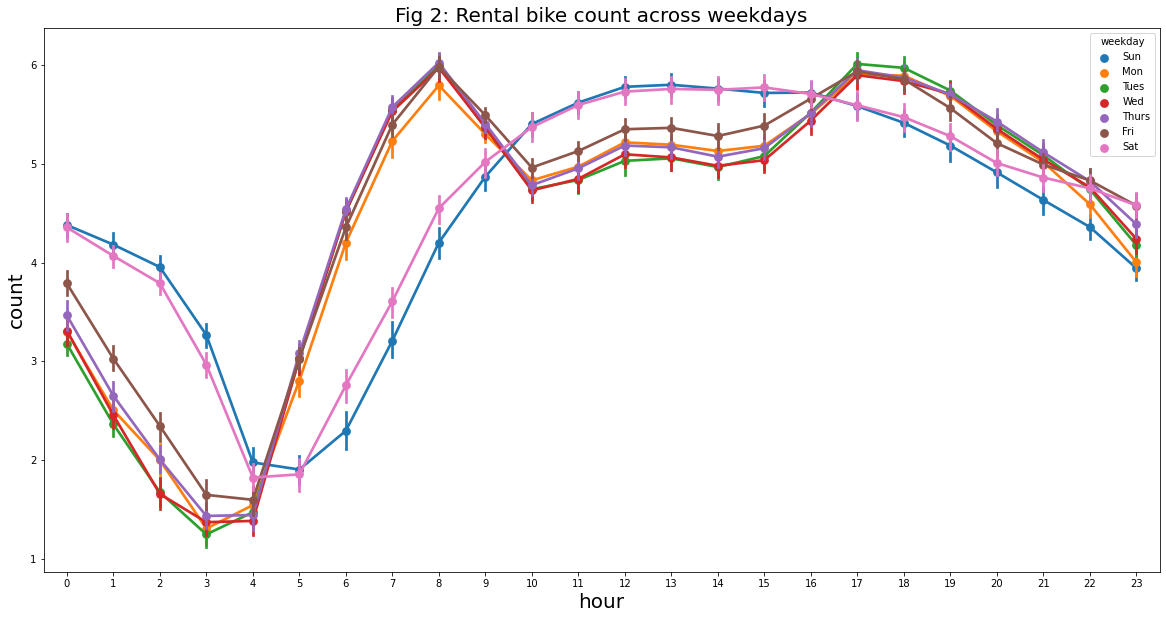

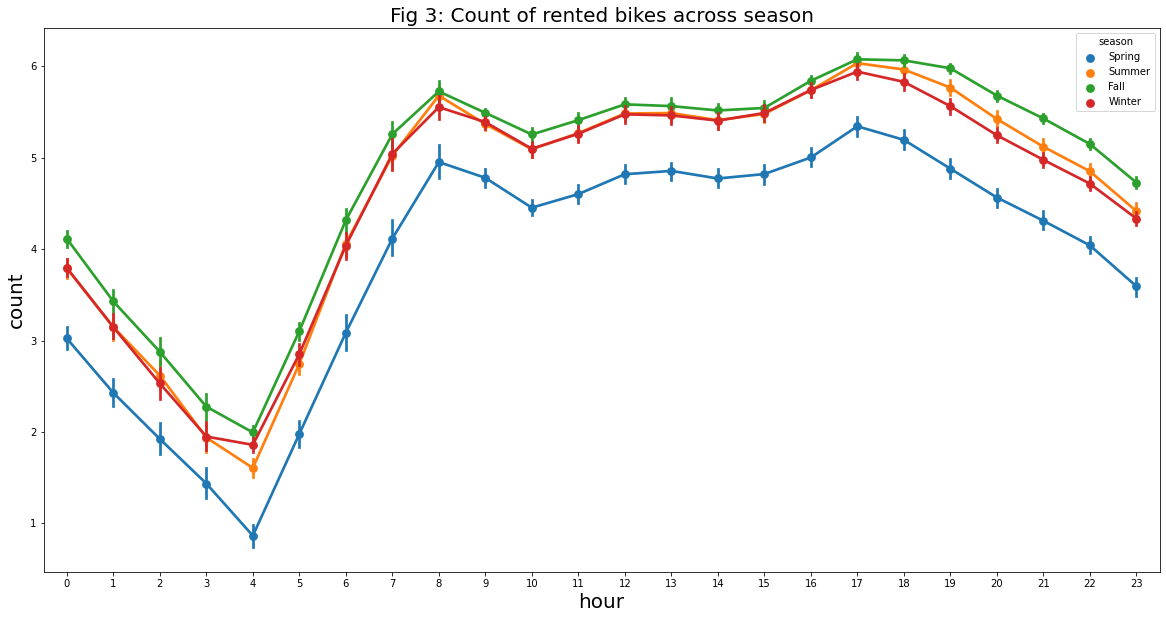

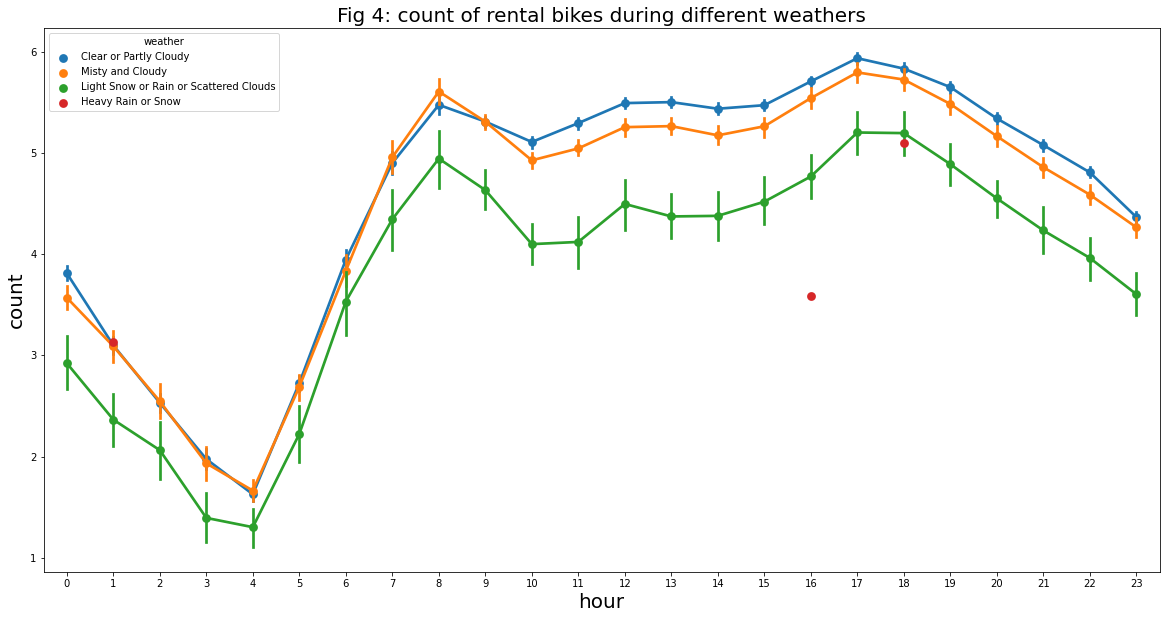

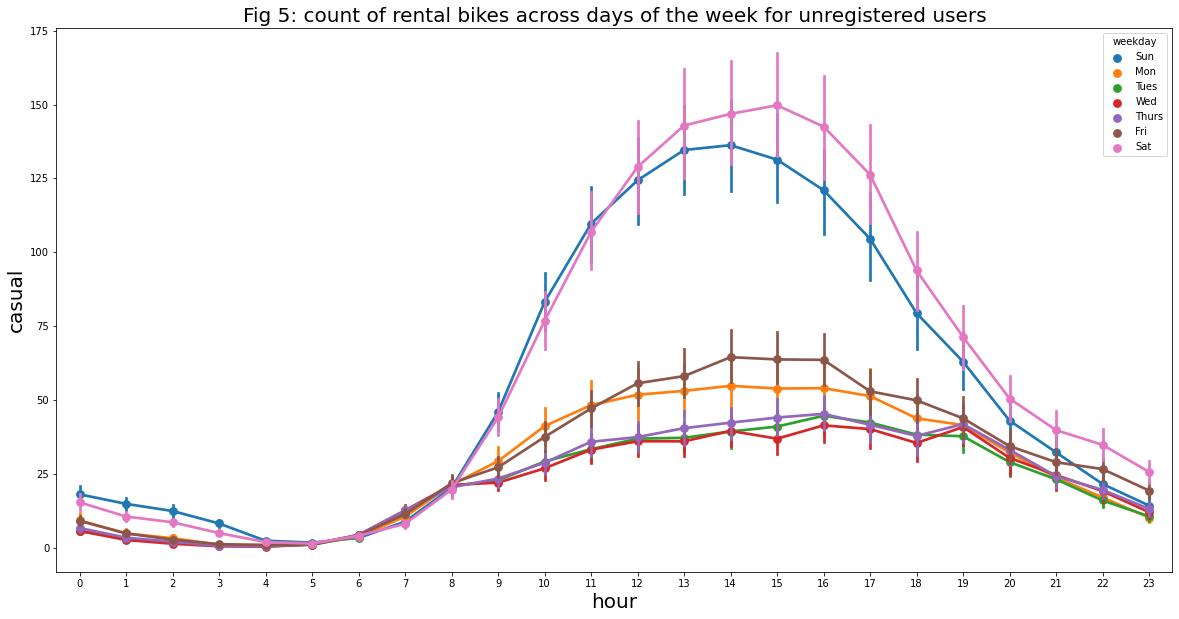

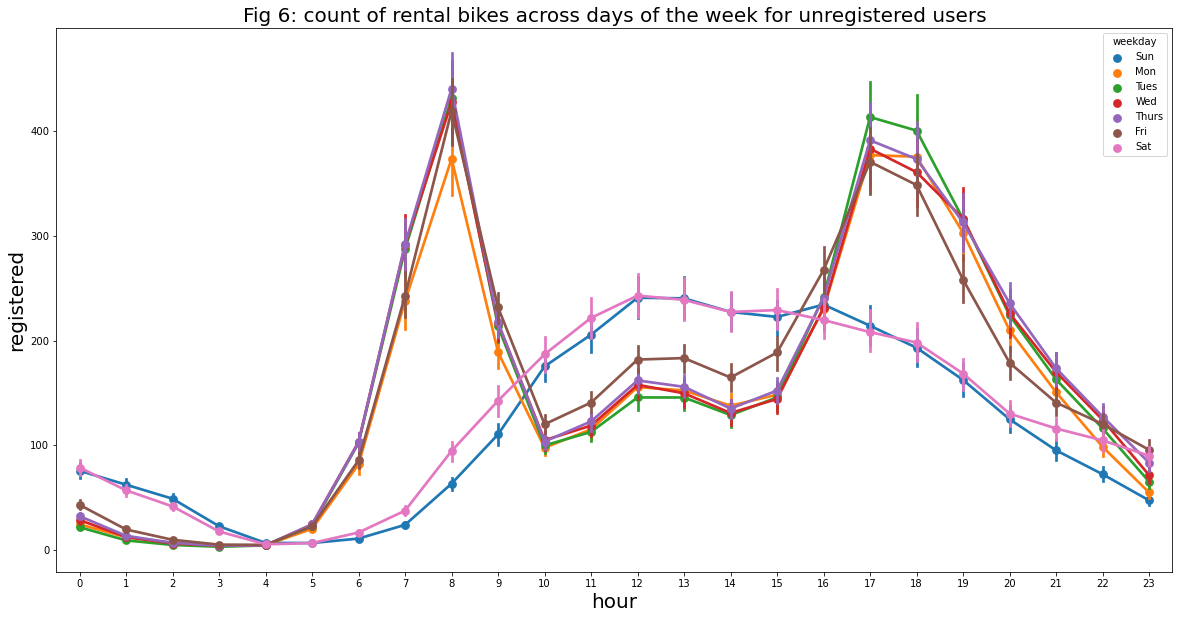

In [12]:
pre_process.exp_data_analysis(df_bike_norm)

Insight from Fig1: <br>
The bike rental count shows a steady gradual increase as we approach the summer(May-Aug). It peaks in June-July. and then starts falling gradually as winter approaches. This is in line with expectation of high usage of bike in summers than in winters. 


Insights from Fig2: <br>
Difference in the patterns on a weekend vs weekday can be clearly seen. On the weekdays, the bike rental peaks out twice in a day, around 7am -8am and then around 5 pm-6 pm. Where as, during weeknds, there is a gradual increase in the bike rental count as the day progresses till 4pm. We see a gradual decrease as we move towards night

Insights from Fig3:<br>
1) The pattern of bike rental counts over hours in the day is same for all the seasons. <br>
2) As seen before, spring is the season with the lowers bike rental counts.

Insights from Fig 5 & 6:

1) The graph for unregistered users might point to the fact that most unregistered users are casual users and they do not show any sharp rise in count during a particular time of the day. The demand rises gradually as the day progresses until 2 pm and then gradually declines. The over all demand is the highest on weekends.

2) The graph for registered users might point to the fact that most resgistered users are regular users. There is a peak in the demand at 7am - 8am and again at 5pm - 6pm on. weekdays probably due to the need of commutation to work place, university, schools during the weekdays.

## STEP 5: Preparing the data to be used in the ML models 

<b> 1) One hot encoding </b>

In [13]:
#One hot encoding all the category features
df_bike = pre_process.one_hot_encoding(df_bike)

<b> 2) Splitting the data into feature space and target space </b>

In [14]:
#Splitting the data into features and target
x, y = pre_process.split_into_dep_target(df_bike, 'count')
print('Features shape is: ', x.shape)
print('Target shape is: ', y.shape)

Features shape is:  (17135, 51)
Target shape is:  (17135,)


<b> 3) Splitting the data into test dataset and train dataset. <b>

In [15]:
train_test_ratio = 0.7
x_train, x_test, y_train, y_test = models.train_test_split(
    x, y, train_test_ratio)

In [16]:
x_train.shape

(11994, 51)

In [17]:
y_train.shape

(11994,)

## STEP 6: Choosing a Model

<b> 1) Multi linear regression: <b>

In [18]:
models.model_lr(x_train,y_train,x_test,y_test)


Mean Absolute error for linear regression:  0.4730629642713058


<b> 2) Random Forest </b> 

In [19]:
models.model_rf(x_train,y_train,x_test,y_test)

Best Parameters using random search: 
 {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
Mean Absolute error for random forest model:  0.4869715558355405


3) <b> XGBOOST </b>

In [22]:
#hyperparameter tuning for estimating the best parameters for the model
hyperparameter_grid={'n_estimators': [100,500,900,1100,1500],
                    'max_depth':[2,3,5,10],
                    'learning_rate':[0.05,0.1,0.15,0.20],
                    'min_child_weight':[1,2,3,4],
                    'booster':['gbtree','gblinear'],
                    'base_score':[0.25,0.5,0.75],
                    'gamma':[0,1]}

In [23]:
models.model_xgb(x_train,y_train,x_test,y_test,hyperparameter_grid)

[06:54:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Estimator for XGBoost: 
 XGBRegressor(base_score=0.75, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True